In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("dataset_bitcoin_returns (1).csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB
None


,returns
0,-0.098023
1,-0.006172
2,0.134714
3,0.004694
4,0.118912


In [21]:
train_split = 0.8
df_train = df.iloc[:int(len(df)*train_split)].copy()
df_test = df.iloc[int(len(df)*train_split):].copy()
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Train: (800, 4)
Test: (200, 4)


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_series(df, title, xlabel='index', ylabel='returns', rolling_windows=[30]):
    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Returns Series
    axes[0].plot(df.index, df[ylabel], color='blue', linewidth=0.8, alpha=0.7, label=ylabel)
    axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=11)
    axes[0].set_ylabel(ylabel, fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot 2: Rolling Standard Deviations
    # Ensure rolling_windows is a list, even if a single integer is passed
    if not isinstance(rolling_windows, list):
        rolling_windows = [rolling_windows]

    for window in rolling_windows:
        rolling_std_name = f'rolling_std_{window}'
        df[rolling_std_name] = df[ylabel].rolling(window=window).std()
        axes[1].plot(df.index, df[rolling_std_name], linewidth=1.2, label=f'Window={window}')


    axes[1].set_title(f'Rolling Standard Deviation for various windows', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Index', fontsize=11)
    axes[1].set_ylabel('Standard Deviation', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(title='Rolling Window Sizes') # Add a legend for different windows

    plt.tight_layout()
    plt.show()

    # ACF and PACF plots for squared returns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    sq_ret = (df[ylabel].dropna().values)**2 # Drop NA if there are any from rolling calculations
    fig.suptitle(f'Autocorrelation and Partial Autocorrelation Functions of Squared ({ylabel.upper()})', fontsize=16, fontweight='bold')
    plot_acf(sq_ret, lags=20, ax=axes[0])
    plot_pacf(sq_ret, lags=20, ax=axes[1]);
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


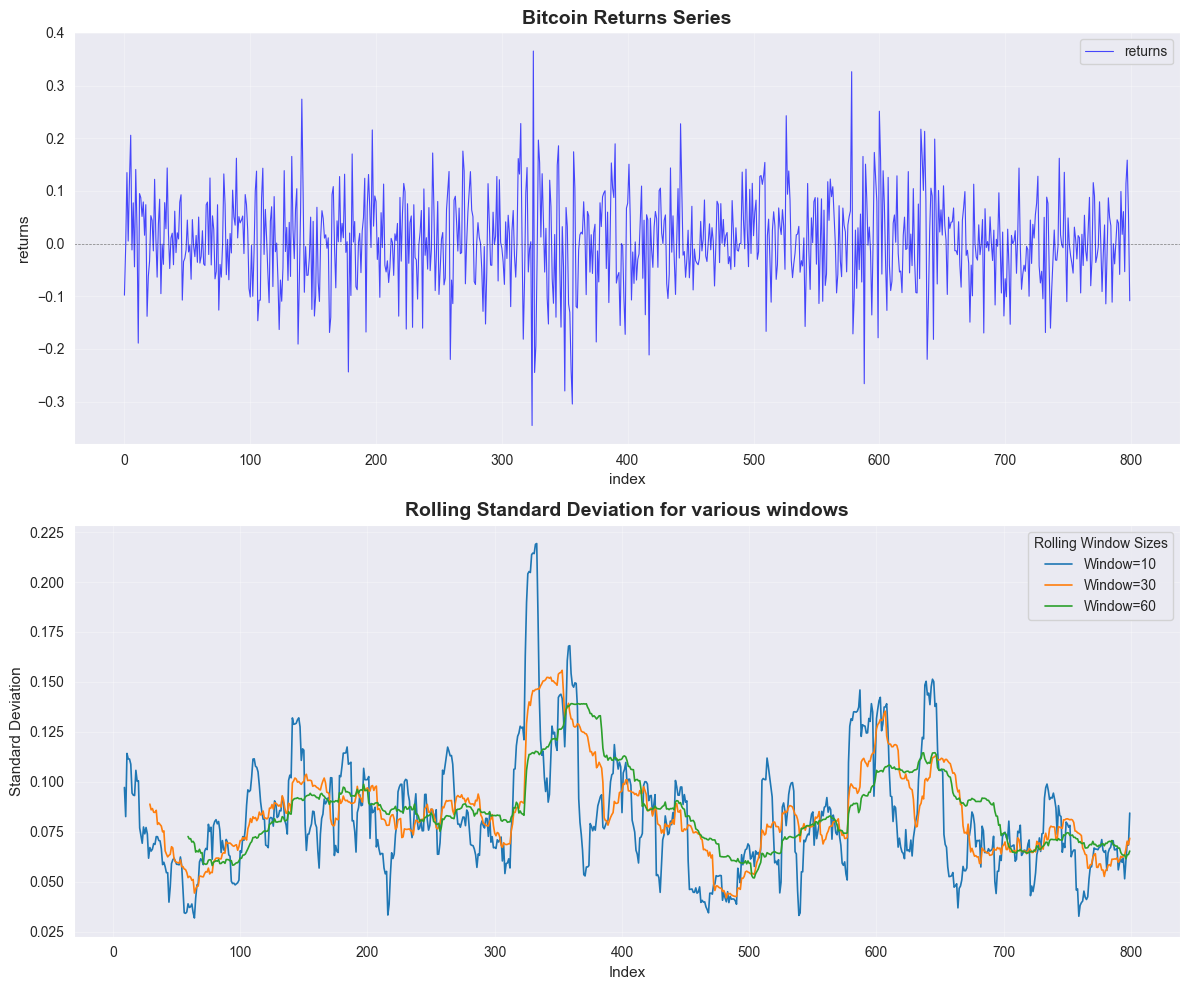

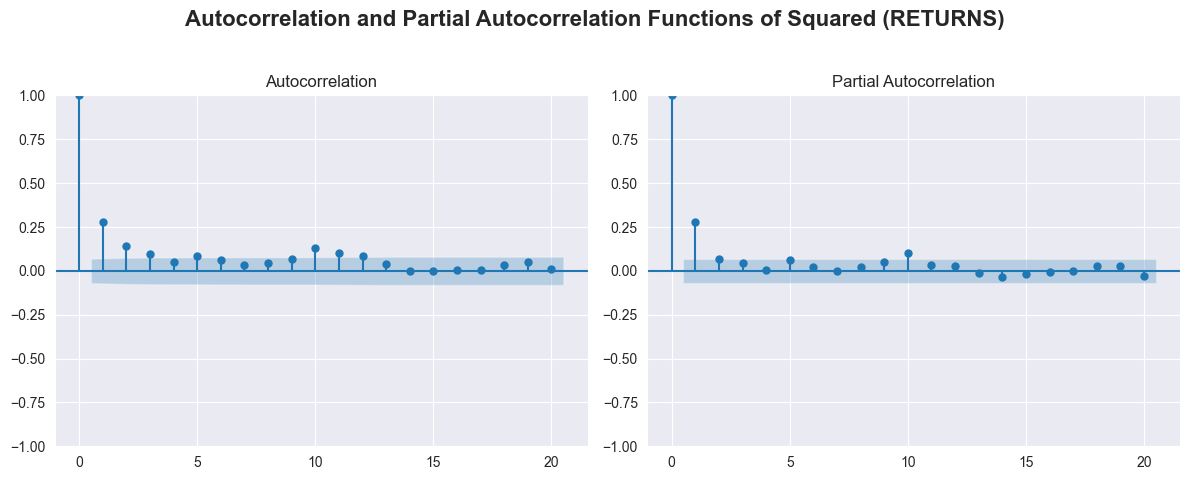

In [22]:
plot_series(df_train, title='Bitcoin Returns Series', rolling_windows=[10,30, 60])

#### Bitcoin Returns Series
The Bitcoin Returns Series (top plot) shows a graph of returns hovering around 0 with varying volatility. There also seems to be clustering of volatility where large fluctuations often were followed by relatively larger fluctuations--and vice versa.

The Rolling Standard Deviation for Various Windows (middle plot) confirms the conclusion above where each window exhibits consistently show elevated volatility during the same periods. This essentially confirms the presence of heteroskedasticity in the series where we have unequal volatility across time.

Naturally, the lesser the window size, the more volatile the series become while higher results to a smoother distribution. We can use this to our advantage when it comes to choosing parameters for GARCH model later.

The ACF and PACF plots of squared returns (bottom plot) provide a strong statistical evidence for conditional heteroskedasticity:

- The ACF shows a positive correlation of current squared returns (a proxy for volatility) with lagged squared returns--specifically the decaying autocorrelations. This indicates that volatility is not random and following a predictable pattern to some extent.
- The PACF shows a significant positive correlations, particularly for lags 1, 5, and 10--suggesting a direct relationship in current and past volatilities. Which is a characteristic of AR(p) model--maybe AR(1) because it has the most apparent Partial Autocorrelation.


These combined observations—volatility clustering, time-varying volatility, and the significant autocorrelations in squared returns—strongly justify the use of a GARCH-type model to capture and forecast the dynamic, conditional variance of Bitcoin returns.


#### Parameters
**AR(1)** - as was indicated earlier, the PACF shows a the most significant positive autocorrelation for lag 1--implying that the current volatility is directly proportional to the last observed volatility.

So let us first start with **ARCH(1)**. For the second model, we will use **GARCH(1,1)**. This is for the sake of comparison and to capture any (possible) momentum volatility in the returns series.

So in summary, **we'll test GARCH(1,0) and GARCH(1,1)**.

In [ ]:
# import sys
# !{sys.executable} -m pip install arch

from arch import arch_model

### ARCH(1) or GARCH(1,0)

In [23]:
from arch import arch_model

mod_10 = arch_model(df_train['returns'], vol='GARCH', p=1, q=0, rescale=True)
res_10 = mod_10.fit(disp='off')

res_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1009.11
Distribution:                  Normal   AIC:                           2024.22
Method:            Maximum Likelihood   BIC:                           2038.27
                                        No. Observations:                  800
Date:                Fri, Nov 14 2025   Df Residuals:                      799
Time:                        17:48:16   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0399  3.041e-02      1.311      0.190 [-1.973e-02,9.947e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6373  4.668e-02     13.653  1.936e-42   [  0.546,  0.729]
alpha[1]       0.1426  4.067e-02      3.506  4.541e-04 [6.290e-02,  0.222]
==========================================================================

Covariance estimator: robust
"""

### GARCH(1,1)


In [24]:
mod_11 = arch_model(df_train['returns'], vol='GARCH', p=1, q=1, rescale=True)
res_11 = mod_11.fit(disp='off')

res_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -999.095
Distribution:                  Normal   AIC:                           2006.19
Method:            Maximum Likelihood   BIC:                           2024.93
                                        No. Observations:                  800
Date:                Fri, Nov 14 2025   Df Residuals:                      799
Time:                        17:48:24   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0475  2.855e-02      1.665  9.597e-02 [-8.430e-03,  0.104]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0393  3.032e-02      1.296      0.195 [-2.014e-02,9.869e-02]
alpha[1]       0.0700  2.681e-02      2.610  9.041e-03    [1.744e-02,  0.123]
beta[1]        0.8771  6.205e-02     14.136  2.270e-45      [  0.756,  0.999]
=============================================================================

Covariance estimator: robust
"""

| **Metric** | **ARCH(1,0)** | **GARCH(1,1)** | **Interpretation** |
|------------|---------------|-----------------|-------------------|
| **Information Criteria** |
| AIC | 2024.22 | **2006.19** | GARCH(1,1) superior (lower is better) |
| BIC | 2038.27 | **2024.93** | GARCH(1,1) superior |
| Log-Likelihood | -1009.11 | **-999.095** | GARCH(1,1) better fit |
| **Parameter Estimates** |
| μ (mean) | 0.0399 | 0.0475 | Similar drift, both insignificant |
| ω (constant) | 0.6373*** | 0.0393 | Dramatically lower baseline in GARCH |
| α₁ (ARCH) | 0.1426*** | 0.0700** | Reduced shock response in GARCH |
| β₁ (GARCH) | - | 0.8771*** | Strong volatility persistence |
| **Persistence** |
| Total (α+β) | 0.143 | **0.947** | GARCH captures long memory |
| Half-life (days) | ~1-2 | ~13 | Shock decay speed |
| **Model Characteristics** |
| Volatility Response | Abrupt | Smooth | GARCH provides gradual transitions |
| Memory | Short | Long | GARCH incorporates history |
| Complexity | Simple (3 params) | Moderate (4 params) | Trade-off justified by fit |

**Key Finding:** GARCH(1,1) decomposes persistence into news impact (7.0%) and volatility momentum (87.7%), revealing Bitcoin volatility is primarily driven by market memory rather than immediate shocks. The near-unity persistence (0.947) suggests volatility clustering is extremely pronounced in this asset.

### Residual Diagnostics

In [8]:
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot


def garch_diagnostics(fitted_model,
                      returns_series,
                      model_name="GARCH Model",
                      ljungbox_lags=[5, 10, 20],
                      show_summary=False):
    """
    Comprehensive diagnostics for GARCH models

    Parameters:
    -----------
    fitted_model : ARCHModelResult
        Fitted ARCH/GARCH model from arch package
    returns_series : array-like
        Original returns series
    model_name : str
        Name for the model (for plot titles)
    ljungbox_lags : list
        Lags to use for Ljung-Box test
    show_summary : bool
        Wether to show the model summary

    Returns:
    --------
    dict : Dictionary with all diagnostic test results
    """

    # Extract residuals
    std_resid = fitted_model.resid / fitted_model.conditional_volatility
    squared_std_resid = std_resid ** 2

    # Create figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle(f'{model_name} Diagnostics', fontsize=14, fontweight='bold')

    # 1. Standardized Residuals Plot
    axes[0, 0].plot(std_resid, alpha=0.7)
    axes[0, 0].set_title('Standardized Residuals')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Time')

    # 2. Squared Standardized Residuals
    axes[0, 1].plot(squared_std_resid, alpha=0.7, color='orange')
    axes[0, 1].set_title('Squared Standardized Residuals')
    axes[0, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Time')

    # 3. Histogram of Standardized Residuals
    axes[0, 2].hist(std_resid, bins=30, density=True, alpha=0.7, color='green')
    xmin, xmax = axes[0, 2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    axes[0, 2].plot(x, stats.norm.pdf(x, 0, 1), 'r-', label='Normal(0,1)')
    axes[0, 2].set_title('Distribution of Std Residuals')
    axes[0, 2].legend()

    # 4. QQ-Plot
    qqplot(std_resid, line='45', ax=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')

    # 5. ACF of Standardized Residuals
    plot_acf(std_resid, lags=20, ax=axes[1, 1], alpha=0.05)
    axes[1, 1].set_title('ACF of Standardized Residuals')

    # 6. ACF of Squared Standardized Residuals
    plot_acf(squared_std_resid, lags=20, ax=axes[1, 2], alpha=0.05)
    axes[1, 2].set_title('ACF of Squared Std Residuals')

    # 7. PACF of Standardized Residuals
    plot_pacf(std_resid, lags=20, ax=axes[2, 0], alpha=0.05)
    axes[2, 0].set_title('PACF of Standardized Residuals')

    # 8. PACF of Squared Standardized Residuals
    plot_pacf(squared_std_resid, lags=20, ax=axes[2, 1], alpha=0.05)
    axes[2, 1].set_title('PACF of Squared Std Residuals')

    # 9. Conditional Volatility
    axes[2, 2].plot(fitted_model.conditional_volatility, color='purple', alpha=0.7)
    axes[2, 2].set_title('Conditional Volatility')
    axes[2, 2].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

    # Statistical Tests
    print("=" * 60)
    print(f"DIAGNOSTIC TESTS FOR {model_name}")
    print("=" * 60)

    # 1. Model Information Criteria
    print("\n1. MODEL FIT CRITERIA:")
    print(f"   Log-Likelihood: {fitted_model.loglikelihood:.2f}")
    print(f"   AIC: {fitted_model.aic:.2f}")
    print(f"   BIC: {fitted_model.bic:.2f}")

    # 2. Ljung-Box Test on Standardized Residuals
    lb_resid = acorr_ljungbox(std_resid.dropna(), lags=ljungbox_lags, return_df=True)
    print("\n2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:")
    print("   (H0: No serial correlation)")
    print(lb_resid[['lb_stat', 'lb_pvalue']].round(4))

    # 3. Ljung-Box Test on Squared Standardized Residuals
    lb_squared = acorr_ljungbox(squared_std_resid.dropna(), lags=ljungbox_lags, return_df=True)
    print("\n3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:")
    print("   (H0: No remaining ARCH effects)")
    print(lb_squared[['lb_stat', 'lb_pvalue']].round(4))

    # 4. ARCH-LM Test
    arch_lm = het_arch(std_resid.dropna(), nlags=5)
    print("\n4. ARCH-LM TEST:")
    print(f"   Statistic: {arch_lm[0]:.4f}")
    print(f"   P-value: {arch_lm[1]:.4f}")
    print(f"   Interpretation: {'No remaining ARCH effects ✓' if arch_lm[1] > 0.05 else 'ARCH effects remain ✗'}")

    # 5. Normality Tests
    jb_test = stats.jarque_bera(std_resid.dropna())
    shapiro_test = stats.shapiro(std_resid.dropna()[:5000] if len(std_resid) > 5000 else std_resid.dropna())

    print("\n5. NORMALITY TESTS:")
    print(f"   Jarque-Bera Statistic: {jb_test[0]:.4f}, P-value: {jb_test[1]:.4f}")
    print(f"   Shapiro-Wilk Statistic: {shapiro_test[0]:.4f}, P-value: {shapiro_test[1]:.4f}")
    print(f"   Interpretation: {'Residuals are normal ✓' if jb_test[1] > 0.05 else 'Residuals are non-normal ✗'}")

    # 6. Persistence (for GARCH models)
    if 'alpha[1]' in fitted_model.params and 'beta[1]' in fitted_model.params:
        persistence = fitted_model.params['alpha[1]'] + fitted_model.params['beta[1]']
        print(f"\n6. VOLATILITY PERSISTENCE (α + β): {persistence:.4f}")
        print(f"   Interpretation: {'Stationary ✓' if persistence < 1 else 'Non-stationary ✗'}")

    # 7. Model Summary
    if show_summary:
        print("\n7. MODEL SUMMARY:")
        print(fitted_model.summary())

    # Return results as dictionary for further use
    results = {
        'aic': fitted_model.aic,
        'bic': fitted_model.bic,
        'loglikelihood': fitted_model.loglikelihood,
        'ljung_box_resid': lb_resid['lb_pvalue'].values,
        'ljung_box_squared': lb_squared['lb_pvalue'].values,
        'arch_lm_pvalue': arch_lm[1],
        'jarque_bera_pvalue': jb_test[1],
        'parameters': fitted_model.params,
        'std_resid': std_resid
    }

    return results

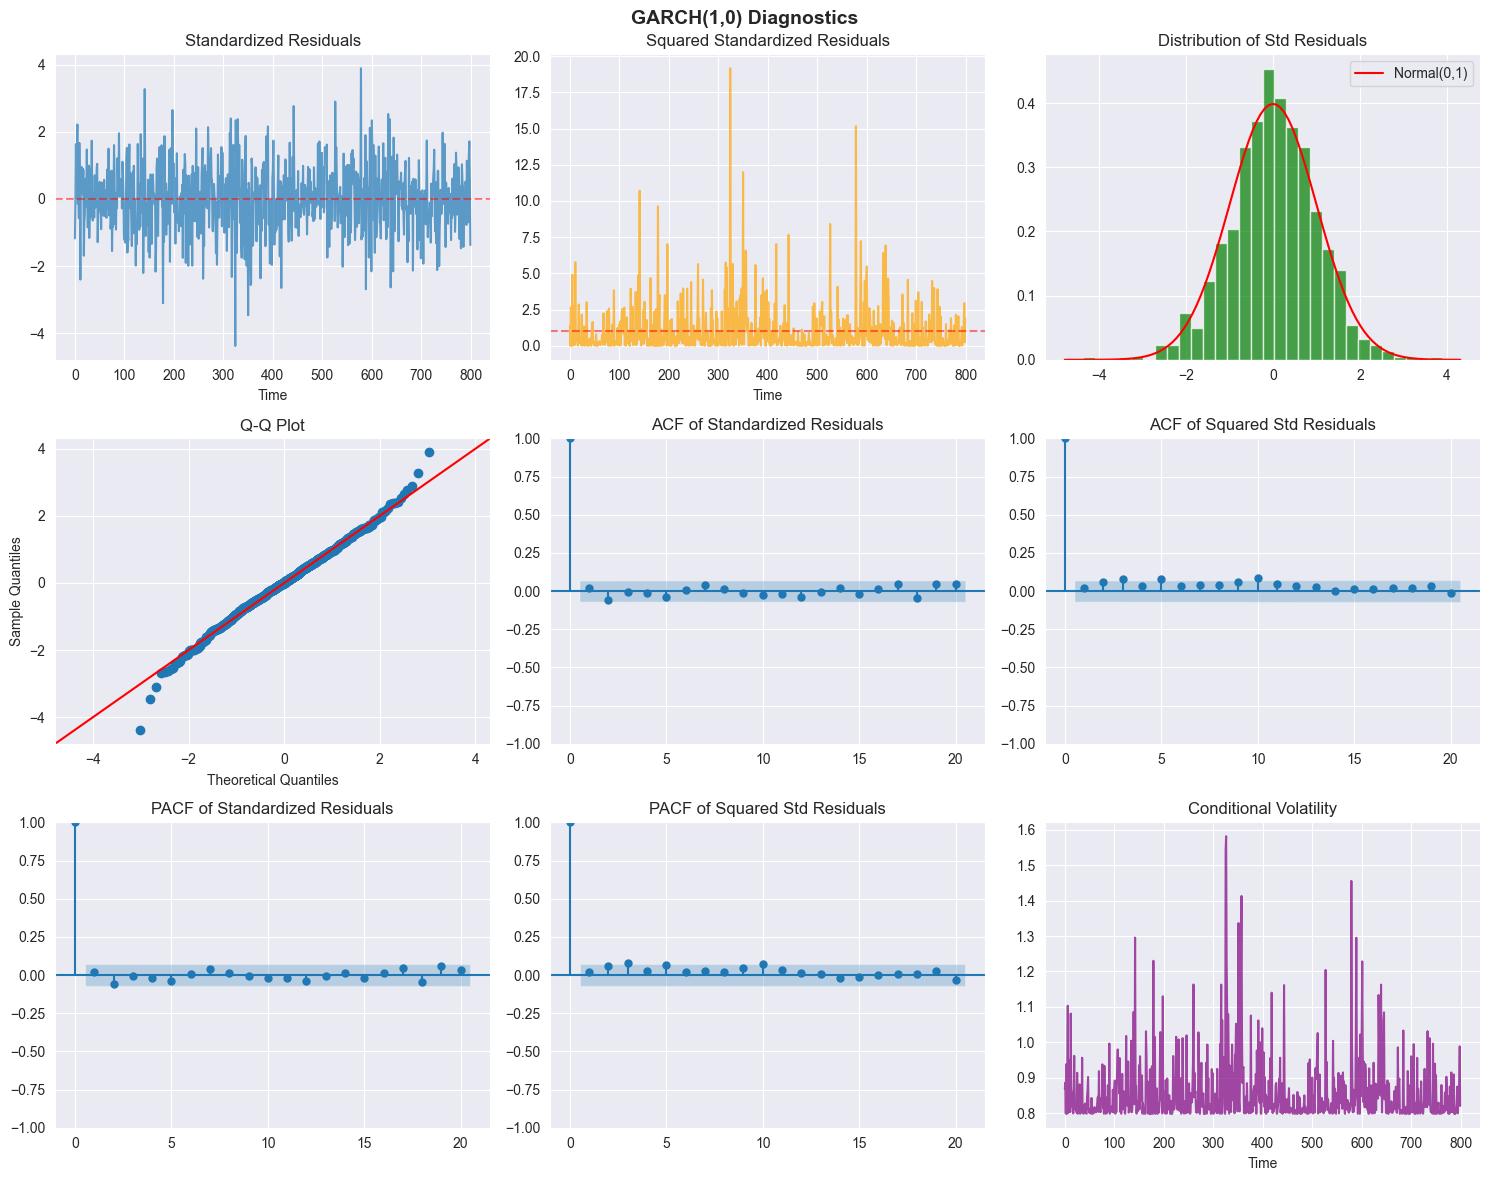

DIAGNOSTIC TESTS FOR GARCH(1,0)

1. MODEL FIT CRITERIA:
   Log-Likelihood: -1009.11
   AIC: 2024.22
   BIC: 2038.27

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    4.4297     0.4893
10   6.7622     0.7477
20  16.0320     0.7146

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5   13.8367     0.0167
10  25.4959     0.0045
20  30.9631     0.0557

4. ARCH-LM TEST:
   Statistic: 12.0959
   P-value: 0.0335
   Interpretation: ARCH effects remain ✗

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 19.6172, P-value: 0.0001
   Shapiro-Wilk Statistic: 0.9956, P-value: 0.0239
   Interpretation: Residuals are non-normal ✗


In [25]:
diag_10 = garch_diagnostics(res_10, df_train['returns'], "GARCH(1,0)")

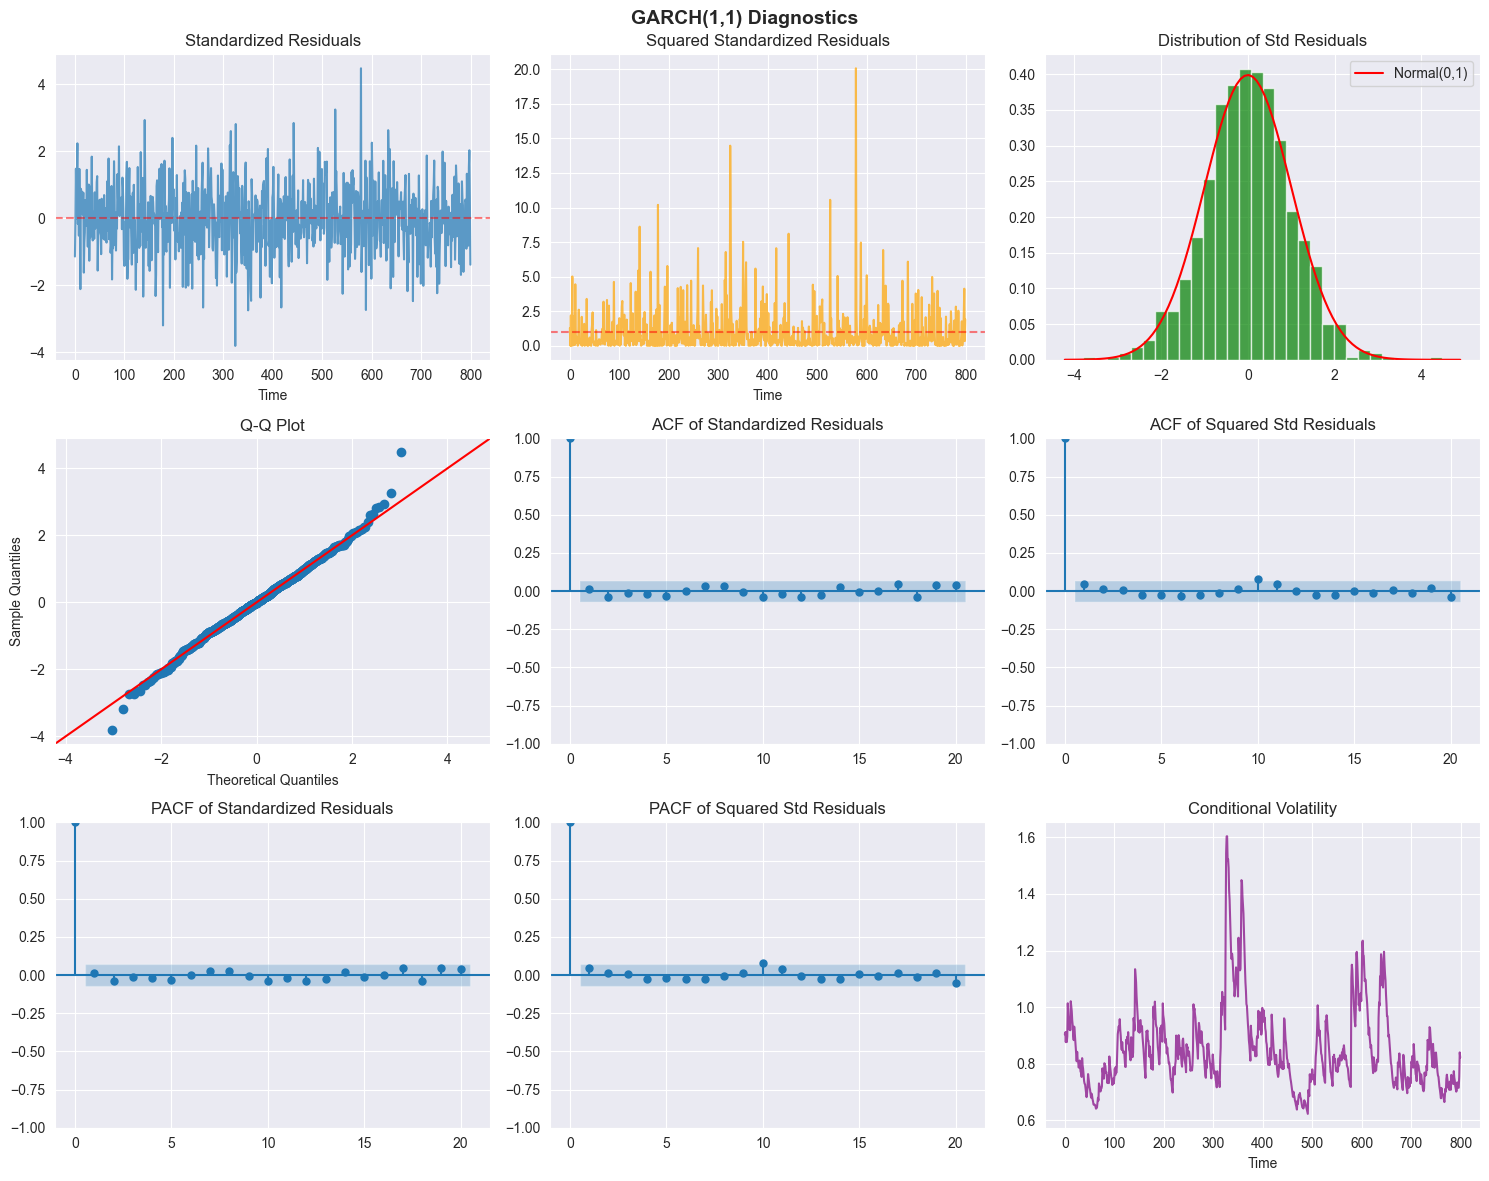

DIAGNOSTIC TESTS FOR GARCH(1,1)

1. MODEL FIT CRITERIA:
   Log-Likelihood: -999.09
   AIC: 2006.19
   BIC: 2024.93

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    2.6835     0.7486
10   5.7701     0.8342
20  13.7477     0.8431

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5    2.7334     0.7410
10   9.5117     0.4843
20  14.3234     0.8137

4. ARCH-LM TEST:
   Statistic: 2.7046
   P-value: 0.7454
   Interpretation: No remaining ARCH effects ✓

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 14.9203, P-value: 0.0006
   Shapiro-Wilk Statistic: 0.9962, P-value: 0.0481
   Interpretation: Residuals are non-normal ✗

6. VOLATILITY PERSISTENCE (α + β): 0.9471
   Interpretation: Stationary ✓


In [26]:
diag_11 = garch_diagnostics(res_11, df_train['returns'], "GARCH(1,1)")

**ARCH(1,0) Inadequacy** :
- The Ljung-Box test on the squared residuals still shows a signifiant level of autocorrelation, meaning the model just isn't capturing volatility persistence
- And the ARCH-LM test confirms that (p = 0.0335) there's still heteroskedasticity in the residuals left to deal with
- The squred residuals also show a clear pattern of spikes at fairly regular intervals, which the simple ARCH model is missing

**GARCH(1,1) Improvements:**
- The residuals are now looking a lot cleaner : all the autocorrelation tests pass (p > 0.48) so we can say we've successfully modelled volatility
- And to show we've fully captured the volatility dynamics theres no remaining ARCH effects (p = 0.7454)
- The Smoother conditional volatility, ie how volatile things are changing, is also looking a lot better--we're now capturing the gradual changes you can see in the bottom-right plot

**Critical Issues in Both Models**:
- Heavy tails : our Q-Q plots are showing a load of extreme deviations at the tails
- Volatility spikes around indices 300 and 600 : these are probably structural breaks

**Suggested Refinements**:
- one way to deal with the heavy tails is to switch to a Student's t distribution
- another thing to look into is EGARCH for leverage effects - ie whether negative returns make things more volatile than positive ones
- and then we've also got Markov-switching GARCH which might do a better job of dealing with the structural breaks we're seeing
- at the moment we're assuming the mean is constant but if the returns show a pattern of autocorrelation we might want to try an AR(1) mean

**Conclusion**: GARCH(1,1) does a much better job of capturing the volatility dynamics but it still needs a Student's t distribution to deal with the tails. To be honest the ARCH(1,0) model is well and truely shot on volatility clustering in the residuals.

In [30]:
final_model = arch_model(df_train['returns'],
                         vol='GARCH',
                         p=1, q=1,
                         rescale=True) # added to address heavy tails
res_fin = final_model.fit(disp='off')
res_fin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -999.095
Distribution:                  Normal   AIC:                           2006.19
Method:            Maximum Likelihood   BIC:                           2024.93
                                        No. Observations:                  800
Date:                Fri, Nov 14 2025   Df Residuals:                      799
Time:                        17:58:41   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0475  2.855e-02      1.665  9.597e-02 [-8.430e-03,  0.104]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0393  3.032e-02      1.296      0.195 [-2.014e-02,9.869e-02]
alpha[1]       0.0700  2.681e-02      2.610  9.041e-03    [1.744e-02,  0.123]
beta[1]        0.8771  6.205e-02     14.136  2.270e-45      [  0.756,  0.999]
=============================================================================

Covariance estimator: robust
"""

In [46]:
def forecast_volatility(fitted_model, returns_series, df_test, horizon=10, model_name=""):
    """
    Forecast conditional volatility with confidence intervals and test data comparison
    """
    # Generate forecasts
    forecasts = fitted_model.forecast(horizon=horizon)
    variance_forecast = forecasts.variance.values[-1, :]

    # Calculate confidence intervals
    std_errors = np.sqrt(2 * variance_forecast / len(returns_series))
    lower_bound = variance_forecast - 1.96 * std_errors
    upper_bound = variance_forecast + 1.96 * std_errors

    # Convert to volatility
    vol_forecast = np.sqrt(variance_forecast)
    vol_lower = np.sqrt(np.maximum(lower_bound, 0))
    vol_upper = np.sqrt(upper_bound)

    # Historical volatility
    hist_vol = fitted_model.conditional_volatility

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Last 50 historical points
    ax.plot(range(-50, 0), hist_vol[-50:], 'b-', alpha=0.7, label='Historical (Train)')

    # Forecast
    forecast_range = range(0, horizon)
    ax.plot(forecast_range, vol_forecast, 'r-', linewidth=2, label='Forecast')
    ax.fill_between(forecast_range, vol_lower, vol_upper,
                     color='red', alpha=0.2, label='95% CI')

    # Actual test data
    test_model = arch_model(df_test['returns'], vol='GARCH', p=1, q=1, rescale=True)
    test_res = test_model.fit(disp='off')
    actual_vol = test_res.conditional_volatility[:horizon]

    # Then plot
    test_range = range(0, len(actual_vol))
    ax.plot(test_range, actual_vol, 'g-', linewidth=2, alpha=0.7,
            label='Actual (Test)', marker='o', markersize=4)

    # Unconditional volatility
    uncond_vol = np.sqrt(fitted_model.params['omega'] /
                        (1 - fitted_model.params.get('alpha[1]', 0) -
                         fitted_model.params.get('beta[1]', 0)))
    ax.axhline(y=uncond_vol, color='purple', linestyle='--',
               alpha=0.5, label=f'Long-run vol: {uncond_vol:.4f}')

    ax.axvline(x=0, color='black', linestyle=':', alpha=0.3)
    ax.set_xlabel('Time')
    ax.set_ylabel('Volatility')
    ax.set_title(f'{model_name} Volatility Forecast vs Actual')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate forecast accuracy
    if len(actual_vol) > 0:
        mse = np.mean((vol_forecast[:len(actual_vol)] - actual_vol.values)**2)
        mae = np.mean(np.abs(vol_forecast[:len(actual_vol)] - actual_vol.values))
        print(f"\nFORECAST ACCURACY:")
        print(f"MSE: {mse:.6f}")
        print(f"MAE: {mae:.6f}")

    # Analysis
    persistence = fitted_model.params.get('alpha[1]', 0) + fitted_model.params.get('beta[1]', 0)
    half_life = np.log(0.5) / np.log(persistence) if persistence < 1 else np.inf

    print(f"\n{model_name} FORECAST ANALYSIS:")
    print(f"Current volatility: {hist_vol.iloc[-1]:.4f}")
    print(f"1-step ahead forecast: {vol_forecast[0]:.4f}")
    print(f"1-step ahead actual: {actual_vol.iloc[0]:.4f}" if len(actual_vol) > 0 else "")
    print(f"Half-life: {half_life:.1f} periods")

    return variance_forecast

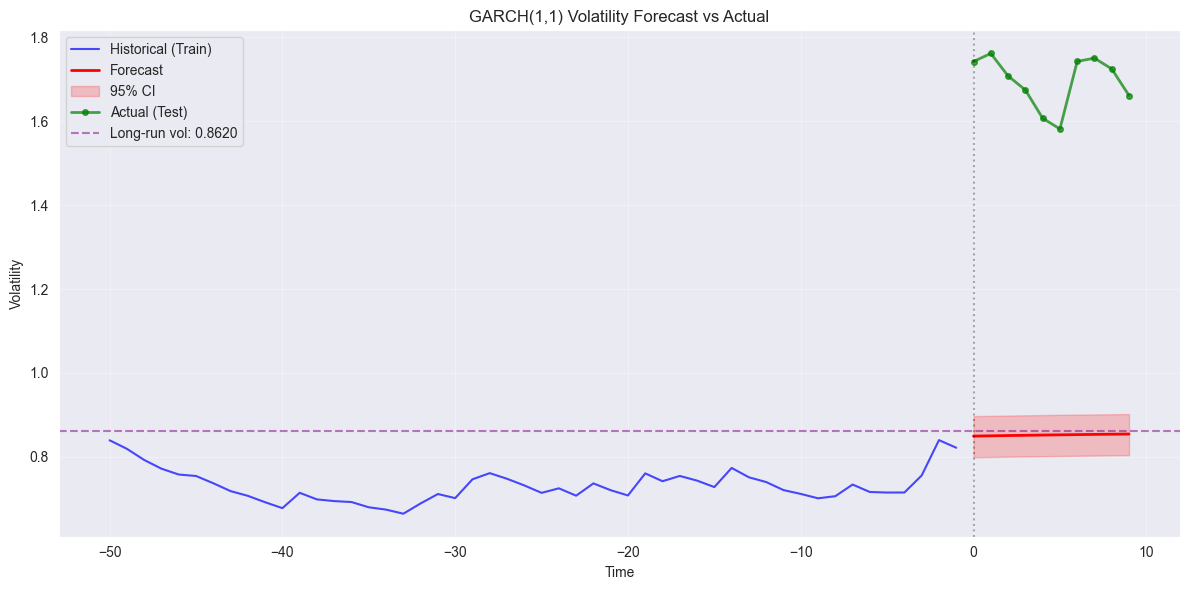


FORECAST ACCURACY:
MSE: 0.714935
MAE: 0.843431

GARCH(1,1) FORECAST ANALYSIS:
Current volatility: 0.8216
1-step ahead forecast: 0.8493
1-step ahead actual: 1.7423
Half-life: 12.8 periods


array([0.72138083, 0.72252267, 0.72360414, 0.72462845, 0.72559861,
       0.72651748, 0.72738779, 0.72821208, 0.72899281, 0.72973226])

In [47]:
forecast_volatility(res_fin, df_train, df_test, horizon=10, model_name="GARCH(1,1)")